## <center>Pet Skin Disease Detection</center>

This notebook contains code for training a deep learning based model using tensorflow for detecting skin diseases in pets.

In [ ]:
# Import OS module
import os

# Imports
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks, layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Notebook magic
%matplotlib inline

In [ ]:
!unzip -q ezyZip.zip -d dataset

print("Unzipped successfully.")

Unzipped successfully.


In [ ]:
# Check if GPU available
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
# Configure variables for Transfer learning
image_size = 224
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)
grid_shape = (1, image_size, image_size, 3)

batch_size = 32

## Load Image data

We will be loading all the images in the dataset and apply augmentations to make the model prepared for all kinds of images.

The Tensorflow and Keras API provides `ImageDataGenerator` for adding the augmentations to be applied to the images, and easily load them from the directory. This automatically keeps track of the class for each image and works seamlessly with the rest of the API.

In [ ]:
dataset_root = "dataset"

train_dir = os.path.join(dataset_root, "train")
test_dir = os.path.join(dataset_root, "valid")

In [ ]:
# Define augmentations for train dataset and read the images
train_aug = ImageDataGenerator(
    # Rescale
    rescale=1/255.0,
    # Filling for W/H shift
    fill_mode="nearest",
    # Width and Height shift
    width_shift_range=0.2,
    height_shift_range=0.2,
    # Random zooms
    zoom_range=0.2,
    # Random Shearing aug
    shear_range=0.2,
)

# Read data from directory
train_data = train_aug.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 3027 images belonging to 6 classes.


In [ ]:
# Get the list of categories in training data
cats = list(train_data.class_indices.keys())

In [ ]:
# Augmentations for test data
test_aug = ImageDataGenerator(
    # Rescale
    rescale=1/255.0
)

# Read data from directory
test_data = test_aug.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 865 images belonging to 6 classes.


## Model building and Training

As mentioned above, We will be performing Transfer learning with Mobilenet V2 model.

We get the model with pre-trained weights through API without the Top layer, and Then stack further layers for prediction.

We used Global Average 2D Pooling for normalization along with dropout, and the final Dense output layer for the prediction.

In [ ]:
# Load the base model
mbnet_v2 = keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape
)

# Stop from being trainable
mbnet_v2.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Define the layers
inputs = keras.Input(shape=input_shape)

# Get the layer
x = mbnet_v2(inputs, training = False)

# Stack layers further
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(cats), activation="softmax")(x)

# Combine the model
model = Model(inputs=inputs, outputs=x)

# Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Compile
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Define callbacks to use
early_stopping_cb = callbacks.EarlyStopping(monitor="loss", patience=3)

In [ ]:
# Num epochs
epochs = 30

# Train model
history = model.fit(
    train_data,
    epochs=epochs,
    steps_per_epoch=150,
    callbacks=[early_stopping_cb]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.4459 - loss: 1.5203
Epoch 2/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.6883 - loss: 0.8583
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.7328 - loss: 0.7170
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.7611 - loss: 0.6736
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.7910 - loss: 0.6002
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.7926 - loss: 0.5762
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.7938 - loss: 0.5692
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.8073 - loss: 0.5274
Epoch 9/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.8225 - loss: 0.5047
Epoch 10/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.8350 - loss: 0.4770
Epoch 11/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.8336 - loss: 0.4695
Epoch 12/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.8501 - loss: 0.4491
Epoch 13/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/st

In [ ]:
model.evaluate(test_data)

28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8539 - loss: 0.4385


[0.4785206615924835, 0.8346821069717407]

## Visualize the model history

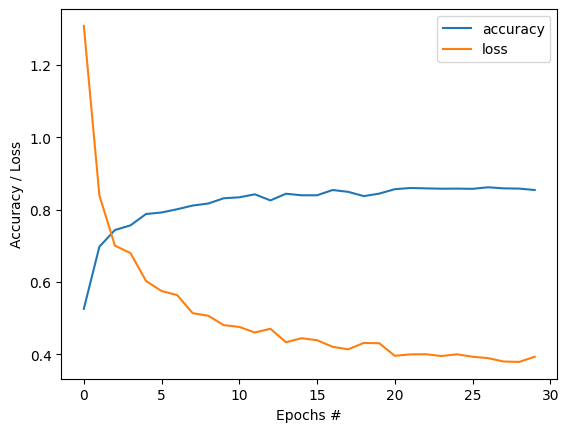

In [ ]:
# Plotting
hist = history.history

# Plot accuracy and loss
plt.plot(hist["accuracy"], label="accuracy")
plt.plot(hist["loss"], label="loss")

if "val_accuracy" in hist and "val_loss" in hist:
    plt.plot(hist["val_accuracy"], label="val_accuracy")
    plt.plot(hist["val_loss"], label="val_loss")

# Add the labels and legend
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epochs #")
plt.legend()

# Finally show the plot
plt.show()

## Save and download the model

We save the model to a file, and link it using IPython to easily get the assets.

In [ ]:
model.save("dog__skin_disease_detection.h5")

In [ ]:
import json

from IPython.display import FileLink

# Link the files
FileLink("./dog__skin_disease_detection.h5")

/content/dog__skin_disease_detection.h5

In [ ]:
# Dump the categories
with open("categories.json", "w") as file:
  json.dump(train_data.class_indices, file)

# Link categories JSON
FileLink("categories.json")

/content/categories.json